In [8]:
import Ramsey_ExperimentV2
import estimator
import numpy as np

In [13]:
from tqdm import tqdm
import random

T = np.pi
uni_delay = np.linspace(0, T, 50)
# shots = np.arange(500, 20000, 2000)
shots= np.logspace(2,6,num=6-2+1,base=10,dtype='int')
errors_fisher = []
errors_local = []
uniform_local = []
n = 5
delay = [0.3]
fisher_delay = [0.147, 0.6]

repetitions = 10
W = [0]*n
Decay = [4]*n
J = [2,-3,2.5,1]

for rep in range(repetitions):
    rep_error_fisher = []
    rep_error_local = []
    rep_error_uniform = []
    # W = [random.gauss(0, 3) for _ in range(n)]
    # Decay = [random.gauss(3, 1) for _ in range(n)]
    # J = [random.gauss(0, 3) for _ in range(n - 1)]
    for s in tqdm(shots, desc=f"Repetition {rep}"):
        batch_x, batch_y = Ramsey_ExperimentV2.ramsey_global(n, s, delay, Decay, W, J)
        batch_x_det, batch_y_det, batch_x_cross, batch_y_cross = Ramsey_ExperimentV2.ramsey_local(n, s, delay, Decay,
                                                                                                  W, J)

        batch_det, batch_cross = Ramsey_ExperimentV2.ramsey_local_X(n, s, fisher_delay, Decay, W, J)
        batch_uni_det, batch_uni_cross = Ramsey_ExperimentV2.ramsey_local_X(n, s, uni_delay, Decay, W, J)

        Decay_local, W_local, J_local = estimator.one_by_one_fit(batch_x_det, batch_y_det, batch_x_cross,
                                                                 batch_y_cross)
        Decay_fisher, W_fisher, J_fisher = estimator.one_by_one_X(batch_det, batch_cross)

        Decay_uni, J_uni, _ = estimator.full_complex_fit(batch_x, batch_y, neighbors=3, W_given=W)


        rep_error_fisher.append(estimator.percent_error(np.concatenate([Decay, W, J]),
                                                        np.concatenate([Decay_fisher, W_fisher, J_fisher])))
        rep_error_local.append(estimator.percent_error(np.concatenate([Decay, W, J]),
                                                       np.concatenate([Decay_local, W_local, J_local])))
        rep_error_uniform.append(estimator.percent_error(np.concatenate([Decay, J]),
                                                         np.concatenate([Decay_uni, J_uni])))

    errors_fisher.append(rep_error_fisher)
    errors_local.append(rep_error_local)
    uniform_local.append(rep_error_uniform)


Repetition 0:   0%|          | 0/5 [00:00<?, ?it/s]C:\Projects\Crosstalk\estimator.py:31: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance, *c = curve_fit(model_func, t_points, z_points, p0=initial_guess)
C:\Projects\Crosstalk\estimator.py:60: OptimizeWarning: Covariance of the parameters could not be estimated
  params, params_covariance, *c = curve_fit(model_func, t_points, z_points, p0=initial_guess, bounds=bounds)
Repetition 9: 100%|██████████| 5/5 [05:45<00:00, 69.08s/it]


In [14]:
errors_fisher_reshaped = list(map(list, zip(*errors_fisher)))
errors_fisher_median = [np.mean(np.array(errors_fisher_reshaped[i])) for i in range(len(errors_fisher_reshaped))]
errors_fisher_std = [np.std(np.array(errors_fisher_reshaped[i])) for i in range(len(errors_fisher_reshaped))]

errors_local_reshaped = list(map(list, zip(*errors_local)))
errors_local_median = [np.mean(np.array(errors_local_reshaped[i])) for i in range(len(errors_local_reshaped))]
errors_local_std = [np.std(np.array(errors_local_reshaped[i])) for i in range(len(errors_local_reshaped))]

errors_uniform_reshaped = list(map(list, zip(*uniform_local)))
errors_uniform_median = [np.mean(np.array(errors_uniform_reshaped[i])) for i in range(len(errors_uniform_reshaped))]
errors_uniform_std = [np.std(np.array(errors_uniform_reshaped[i])) for i in range(len(errors_uniform_reshaped))]

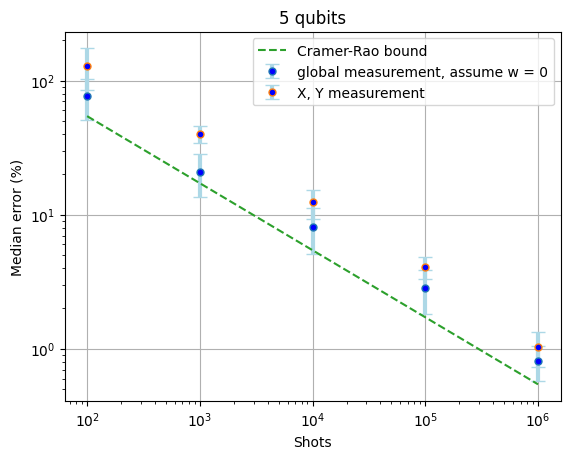

In [22]:
import matplotlib.pyplot as plt

# plt.plot(shots, errors_global_median, '-^', label='Global')
# plt.plot(shots, errors_local_median, '-^', label='Local')
# plt.plot(shots, errors_fisher_median, '-^', label='Fisher')
# plt.plot(shots, errors_uniform_median, '-^', label='Uniform')
# plt.errorbar(shots, errors_fisher_median, yerr=errors_fisher_std, fmt='none', ecolor='red')
# plt.errorbar(shots, errors_local_median, yerr=errors_local_std, fmt='none', ecolor='black')

plt.errorbar(shots, errors_uniform_median, yerr=errors_uniform_std, fmt='o', capsize=5, ecolor='lightblue', elinewidth=3, markerfacecolor='blue', markersize=5, label='global measurement, assume w = 0')
plt.errorbar(shots, errors_local_median, yerr=errors_local_std, fmt='o', capsize=5, ecolor='lightblue', elinewidth=3, markerfacecolor='blue', markersize=5, label='X, Y measurement')
# plt.errorbar(shots, errors_fisher_median, yerr=errors_fisher_std, fmt='o', capsize=5, ecolor='peachpuff', elinewidth=3, markerfacecolor='orange', markersize=5, label='X measurement at optimal times')


# plt.title(f'Error vs shots W={W} Decay={Decay} ')
plt.title(f'{n} qubits')
plt.plot(shots, np.e * np.sqrt(Decay[0]) / np.sqrt(shots) * 100, '--', label='Cramer-Rao bound')
plt.xlabel('Shots')
plt.ylabel('Median error (%)')
plt.yscale('log')
plt.xscale('log')
plt.grid()

plt.legend()